# Shapiro Diagram with RSJ in Si Unit
### Cythonized
### power in dBm with a guess attenuation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
from scipy.io import savemat
from scipy.integrate import odeint

In [2]:
%load_ext Cython

### Resistively Shunted Model:

$\frac{d\phi}{dt}=\frac{2eR_N}{\hbar}[I_{DC}+I_{RF}\sin(2\pi f_{RF}t)-I_C\sin\phi]$

Solving $\phi(t)$, then you can get the voltage difference between the superconducting leads:

$V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle$

After Normalizing:
$I_{DC}\leftrightarrow \tilde{I_{DC}}=I_{DC}/I_C$,

$I_{RF} \leftrightarrow \tilde{I_{RF}}=I_{RF}/I_C$,

$ V \leftrightarrow \tilde{V}=\frac{V}{I_CR_N}$,

$ R=\frac{dV}{dI} \leftrightarrow \tilde{R}=\frac{R}{R_N}$,


$\because f_0=2eI_CR_N/h$,

$f_{RF} \leftrightarrow \tilde{f_{RF}}=f_{RF}/f_0$,

$t \leftrightarrow \tilde{t}=f_0t$,

The Josephson voltage quantized at $\frac{V}{hf_{RF}f_0/2e}=n \leftrightarrow \frac{V}{f_{RF}f_0}=n$ 

Here, we can set $f_0=1$ or $\frac{I_CR_N}{hf_0/2e}=1$, without loss of generality

The RSJ model simply becomes (omitting $\tilde{}$):

$\frac{d\phi}{dt}=[I_{DC}+I_{RF}\sin(2\pi f_{RF}t)-\sin\phi]$

At equilibrium, $V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle \leftrightarrow \tilde{V}=\frac{1}{2\pi}\langle\frac{d\phi}{d\tilde{t}}\rangle$  would also quantized at integers in the Shapiro step regime.



### Cython codes here is to speed up the simulation because python is slower than C:

In [19]:
%%cython --pgo

#Use GNU compiler gcc-10 specified in .bash_profile
cimport numpy as np
from libc.math cimport sin, pi
import numpy as np


cdef double Qe=1.608e-19
cdef double hbar=6.626e-34/2/pi


### cdef is faster but can only be used for cython in this cell
#cpdef can be used for python outside this cell

cdef double CPR(double A, double G, double C):
    '''
        Current-phase relation for the junction
    '''
    return sin(G) + A*sin(2*G +C*pi)

cdef double i(double t,double i_dc,double i_ac,double f_rf):
    '''
        Applied current
    '''
    return i_dc + i_ac * sin(2*pi*f_rf*t)
    
cpdef dGdt(y,double t,double i_dc,double i_ac,double f_rf,double A, double C, double Ic, double Rn):
    '''
        Define RSJ model
    '''
    der = 2*Qe*Rn/hbar*(-Ic*CPR(A,y,C) + i(t,i_dc,i_ac,f_rf))
    return der 

In [20]:
Qe=1.608e-19
h=6.626e-34
hbar=6.626e-34/2/np.pi
Ic=2e-6
Rn=13.0
w0=2*Qe*Ic*Rn/hbar
f0=w0/2/np.pi

attenuation =-40 # A guess value

#C_array = np.array([0.16])*np.pi

f_array=np.array([1.5])#,1.1,0.9,0.6,0.5])
A=0.909
C_array=[0.16] # as a unit of pi
IDC_step=0.05
IDC_array=np.arange(-5,5+IDC_step/2,IDC_step)*Ic
PRF_step=1
PRF_array=np.arange(-25+attenuation,-24+attenuation+PRF_step/2,PRF_step)
IRF_array = np.sqrt(10**(PRF_array/10)/Rn/1000)/Ic
print("DC array size: "+str(len(IDC_array)))
print("RF array size: "+str(len(PRF_array)))
print("Charecteristic frequency fc = "+str(w0/1e9/2/np.pi)+" GHz")
print("Driving RF frequency f_rf = "+str(f_array*w0/1e9/2/np.pi)+" GHz")
print("C = "+str(C_array)+"*pi")

DC array size: 201
RF array size: 2
Charecteristic frequency fc = 12.619378207063084 GHz
Driving RF frequency f_rf = [18.92906731] GHz
C = [0.16]*pi


### Test at one RF current

In [21]:
t=np.arange(0,300.01,0.01)/f0/f_array[0]
V=np.empty([len(IDC_array)])
for i in range(0,len(IDC_array)):
    G_array= odeint(dGdt,0,t,args=(IDC_array[i],2e-6,f_array[0]*f0,A,C_array[0],Ic,Rn))
    V[i]=np.mean(np.gradient(G_array[:-1501,0]))/(0.01/f0/f_array[0])*hbar/2/Qe


JV=h*f_array[0]*f0/2/Qe

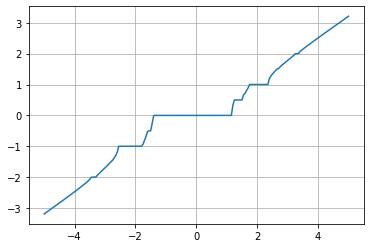

In [22]:
plt.figure()
plt.plot(IDC_array/Ic,V/JV)
plt.grid()

### Plot Shapiro diagram with loops of f and C

f= 1.5*f0, A= 0.909, C= 0.16pi
2020-09-24 17:03:34.342185
It takes 0:00:37.111253020-09-24 17:03:52.714490


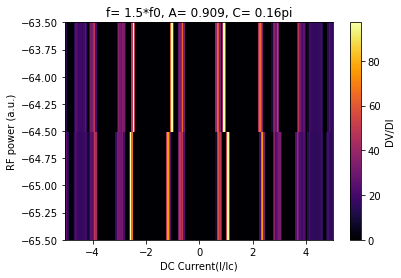

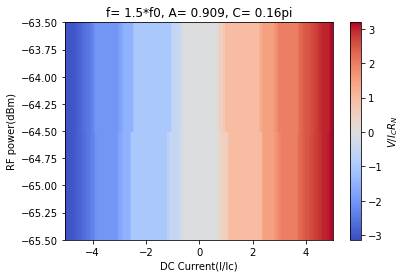

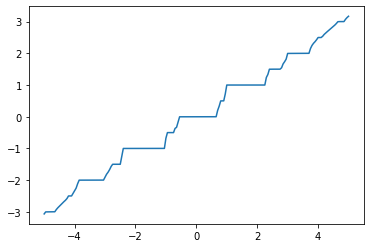

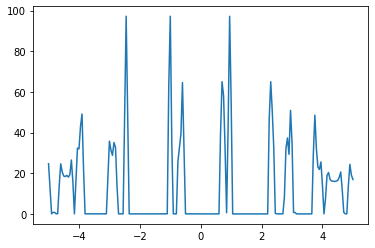

file saved
f= 1.5*f0, A= 0.909, C= 0.84pi
2020-09-24 17:04:12.688235
It takes 0:00:28.467188020-09-24 17:04:27.037302


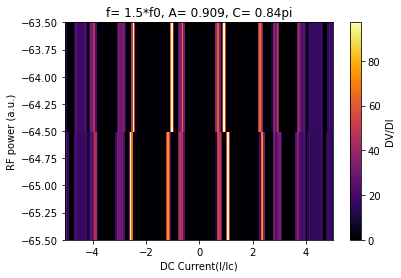

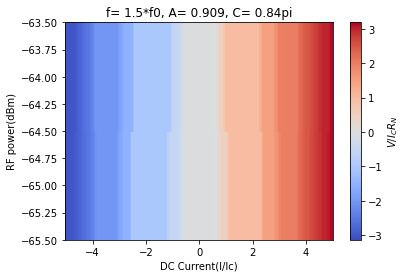

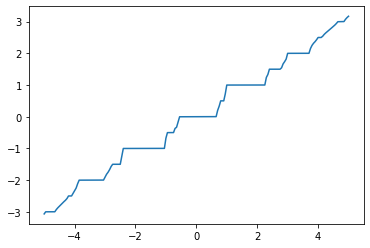

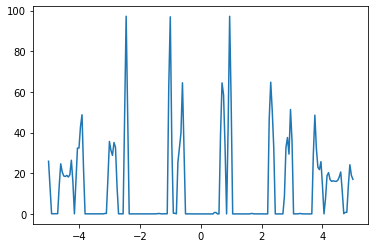

file saved


In [30]:
for f in f_array:
    for C in C_array:
        _name_file = "f_" +str(f)+"f0_A"+str(np.round(A,3))+"_C"+str(np.round(C,2))+"pi"
        _name_title = "f= " +str(f)+"*f0, A= "+str(np.round(A,3))+", C= "+str(np.round(C,2))+"pi"
        print(_name_title)
        T1=datetime.now()
        print (T1)
        WB_Freq=np.empty([len(IRF_array),len(IDC_array)])
        for i in range(0,len(IRF_array)):
            print("RF power now: "+str(i)+" of "+str(len(IRF_array))+" ,"+str(datetime.now()),end="\r")
            for j in range(0,len(IDC_array)):
                t=np.arange(0,300.01,0.01)/f/f0
                G_array= odeint(dGdt,0,t,args=(IDC_array[j],IRF_array[i],f*f0,A,C,Ic,Rn))
                WB_Freq[i,j]=np.mean(np.gradient(G_array[:-1501,0]))/(0.01/f0/f)*hbar/2/Qe # in the unit of V

        DVDI=np.gradient(WB_Freq,IDC_step*Ic,axis=1)

        print ("It takes " + str(datetime.now()-T1))                
        
        plt.figure()
        plt.pcolormesh(IDC_array, PRF_array, DVDI, cmap = 'inferno', vmin = 0,linewidth=0,rasterized=True,shading="auto")
        plt.xlabel("DC Current(I/Ic)")
        plt.ylabel("RF power (a.u.)")
        plt.colorbar(label = "DV/DI")
        plt.title(_name_title)
        #plt.savefig("DVDI_"+_name_file+".pdf")
        plt.show()
        
        JV=h*f*f0/2/Qe

        plt.figure()
        plt.pcolormesh(IDC_array, PRF_array, WB_Freq/JV, cmap = 'coolwarm',linewidth=0,rasterized=True,shading="auto")#/(np.pi*hbar*f/Qe)
        plt.xlabel("DC Current(I/Ic)")
        plt.ylabel("RF power(dBm)")
        plt.colorbar(label = "$V/(hf/2e)$")
        plt.title(_name_title)
        #plt.savefig("V_"+_name_file+".pdf")
        plt.show()

        plt.figure()
        plt.plot(IDC_array,WB_Freq[1,:]/JV)#/(np.pi*hbar*f/Qe))
        plt.show()
        plt.figure()
        plt.plot(IDC_array,DVDI[1,:])
        plt.show()
        #savemat("data"+_name_file+'.mat',mdict={'IDC':IDC_array,'IRF':IRF_array,'PRF':PRF_array,'A':A, 'freq':f_rf,'C':C,'Vmatrix':WB_Freq/w_rf,'DVDI':DVDI})
        print('file saved')